<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# calculating the implied volatility
import pandas as pd
import numpy as np
from math import *
from scipy.stats import norm
import matplotlib.pyplot as plt

# cumulative distribution of Normal distribution
# return the normal distribution quantile
def normal(x):
    # return norm.cdf(x) we could use this instead
    if abs(x)<=10:
        dx = 0.01*abs(x)
        s = 0
        for i in range(0,100):
            t_x = i*dx
            n_x = (i+1)*dx
            s0 = (exp(-t_x**2/2)/sqrt(2*pi)+exp(-n_x**2/2)/sqrt(2*pi))*dx/2
            s = s+s0
        return 0.5+np.sign(x)*s
    elif x<=-10:
        return 0
    else:
        return 1

In [2]:
# For european call&put calculate the difference between estimation of price and real market price
def f(S,r,yield_,T,E,C,x,type_):
    # x is the sigma, the implied volatility
    d1 = (log(S/E)+(r-yield_+0.5*x**2)*T)/(x*sqrt(T))
    # print(S*normal(d1)-E*exp(-r*T)*normal(d1-x*sqrt(T)))
    if type_ == 'c':
        return C-S*np.exp(-yield_*T)*normal(d1)+E*exp(-r*T)*normal(d1-x*sqrt(T))
    else:
        return C-(-S*np.exp(-yield_*T)*normal(-d1)+E*exp(-r*T)*normal(-d1+x*sqrt(T)))

# for the first derivative of f
def df(S,r,yield_,T,E,C,x,type_):
    if type_ == 'c':
        return -S*np.exp(-yield_*T)*sqrt(T)*normal(log(S)-log(E)+(r+0.5*x**2-yield_)*T)/(x*sqrt(T))
    else:
        return -S*np.exp(-yield_*T)*sqrt(T)*normal(log(S)-log(E)+(r+0.5*x**2-yield_)*T)/(x*sqrt(T))
# df(0.75,0.1,5,1,0.1,1.6)

In [3]:
def Newton(v0,S,r,yield_,T,E,C,type_):
    '''
    v0: initial volatility
    S: stock price
    r: risk free rate
    T: Time to maturity
    E: strike price
    C: Call option Price
    '''
    count = 1
    v_1 = v0-f(S,r,yield_,T,E,C,v0,type_)/df(S,r,yield_,T,E,C,v0,type_)
    f_v = f(S,r,yield_,T,E,C,v_1,type_)
    while abs(v_1-v0)>10**(-6) or abs(f_v)>10**(-6):
        count = count+1
        if count>1000:
            return None,None
        v0 = v_1
        v_1 = v0-f(S,r,yield_,T,E,C,v0,type_)/df(S,r,yield_,T,E,C,v0,type_)
        f_v = f(S,r,yield_,T,E,C,v_1,type_)
    return v_1,count

def Bi_Section_M(a,b,S,r,yield_,T,E,C,type_):
    h = (a+b)/2
    f_h = f(S,r,yield_,T,E,C,h,type_)
    count = 0
    while abs(f_h)>10**(-6):
        count = count+1
        if count>1000:
            return None,None
        if f_h>0:
            a=h
        else:
            b=h
        h = (a+b)/2
        f_h = f(S,r,yield_,T,E,C,h,type_)
    return h,count

In [4]:
S = 119
T = 0.25
r = 0.02
Call_price_array = [7.95,5.7,4.22,3,2.16]
E_array = np.arange(120,145,5)
v_n = []
v_b = []

In [5]:
# Calculation for call price
for i in range(len(Call_price_array)):
    if Call_price_array[i]<S and Call_price_array[i]>(S-E_array[i]*exp(-r*T)):
        b_sigma, b_count = Bi_Section_M(0.0001,2,S,r,0.03,T,E_array[i],Call_price_array[i],'c')
        v0 = sqrt(2*abs(log(S/E_array[i])+r*T)/T)
        N_sigma,N_count = Newton(v0,S,r,0.03,T,E_array[i],Call_price_array[i],'c')
    else:
        b_sigma = None
        b_count = None
        N_sigma,N_count = None,None
        print('Wrong')
    v_b.append(b_sigma)
    v_n.append(N_sigma)
    # i_b.append(b_count)
    # i_n.append(N_count)

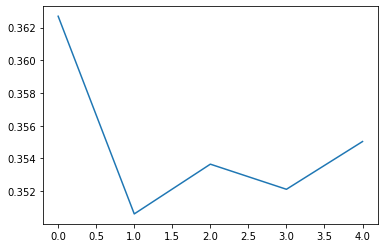

In [6]:
plt.plot(v_n)

In [7]:
v_b

[0.3626972757428885,
 0.35060570725202567,
 0.35364872983694084,
 0.35211237773001197,
 0.35503363411426553]

In [8]:
# Calculation for put price
Put_price_array = [1.13,1.68,2.4,3.45,4.95,6.54]
Ep_array = np.arange(90,120,5)
vp_n = []
vp_b = []
for i in range(len(Put_price_array)):
    b_sigma, b_count = Bi_Section_M(0.0001,2,S,r,0.03,T,Ep_array[i],Put_price_array[i],'p')
    v0 = sqrt(2*abs(log(S/Ep_array[i])+r*T)/T)
    N_sigma,N_count = Newton(v0,S,r,0.03,T,Ep_array[i],Put_price_array[i],'p')
    vp_b.append(b_sigma)
    vp_n.append(N_sigma)
    # i_b.append(b_count)
    # i_n.append(N_count)

In [9]:
vp_b

[0.4410596966326237,
 0.42344192140698445,
 0.40360112329721454,
 0.38861213908791536,
 0.3794369992464781,
 0.35629355370104315]

In [10]:
vp_n

[0.44105979226361475,
 0.4234420080694112,
 0.4036011509782819,
 0.3886122428327767,
 0.3794370426221424,
 0.35629359296334684]